<a href="https://colab.research.google.com/github/DataWhizML/Brain-Tumor-Classificarion-using-ResNet50/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras import backend as k
from skimage import io
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# pip install keras_preprocessing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import display
from tensorflow.keras import backend as K
import os
%matplotlib inline

In [ ]:
brain_df = pd.read_csv('/content/data_mask.csv')

In [ ]:
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [ ]:
brain_df.isna().sum()

patient_id    0
image_path    0
mask_path     0
mask          0
dtype: int64

In [ ]:
brain_df.shape

(3929, 4)

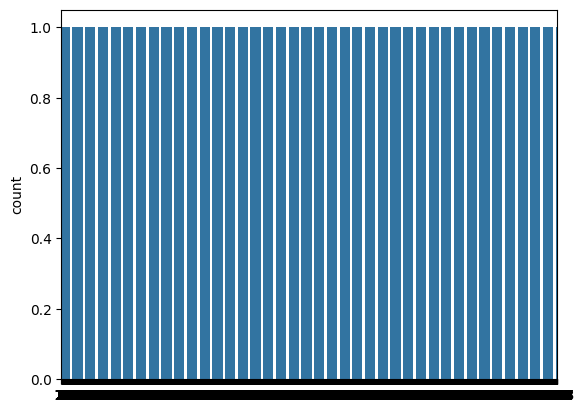

In [ ]:
sns.countplot(brain_df['mask'])
plt.show()

In [ ]:
brain_df.image_path[0]

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif'

In [ ]:
brain_df.mask_path[0]

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif'

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
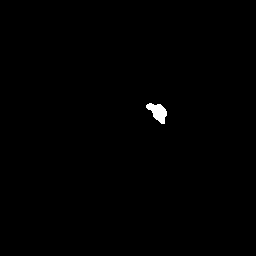

In [ ]:
cv2.imread(r'/content/drive/MyDrive/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_mask.tif')

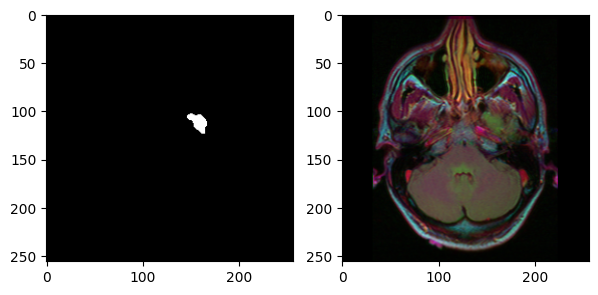

In [ ]:
# case when we have brain tumor
folder_path = '/content/drive/MyDrive/kaggle_3m/'
fig, axes = plt.subplots(1, 2, figsize=(7,7))
axes[0].imshow(cv2.imread(folder_path+ brain_df.mask_path[445]))
axes[1].imshow(cv2.imread(folder_path+brain_df.image_path[445]))
plt.show()

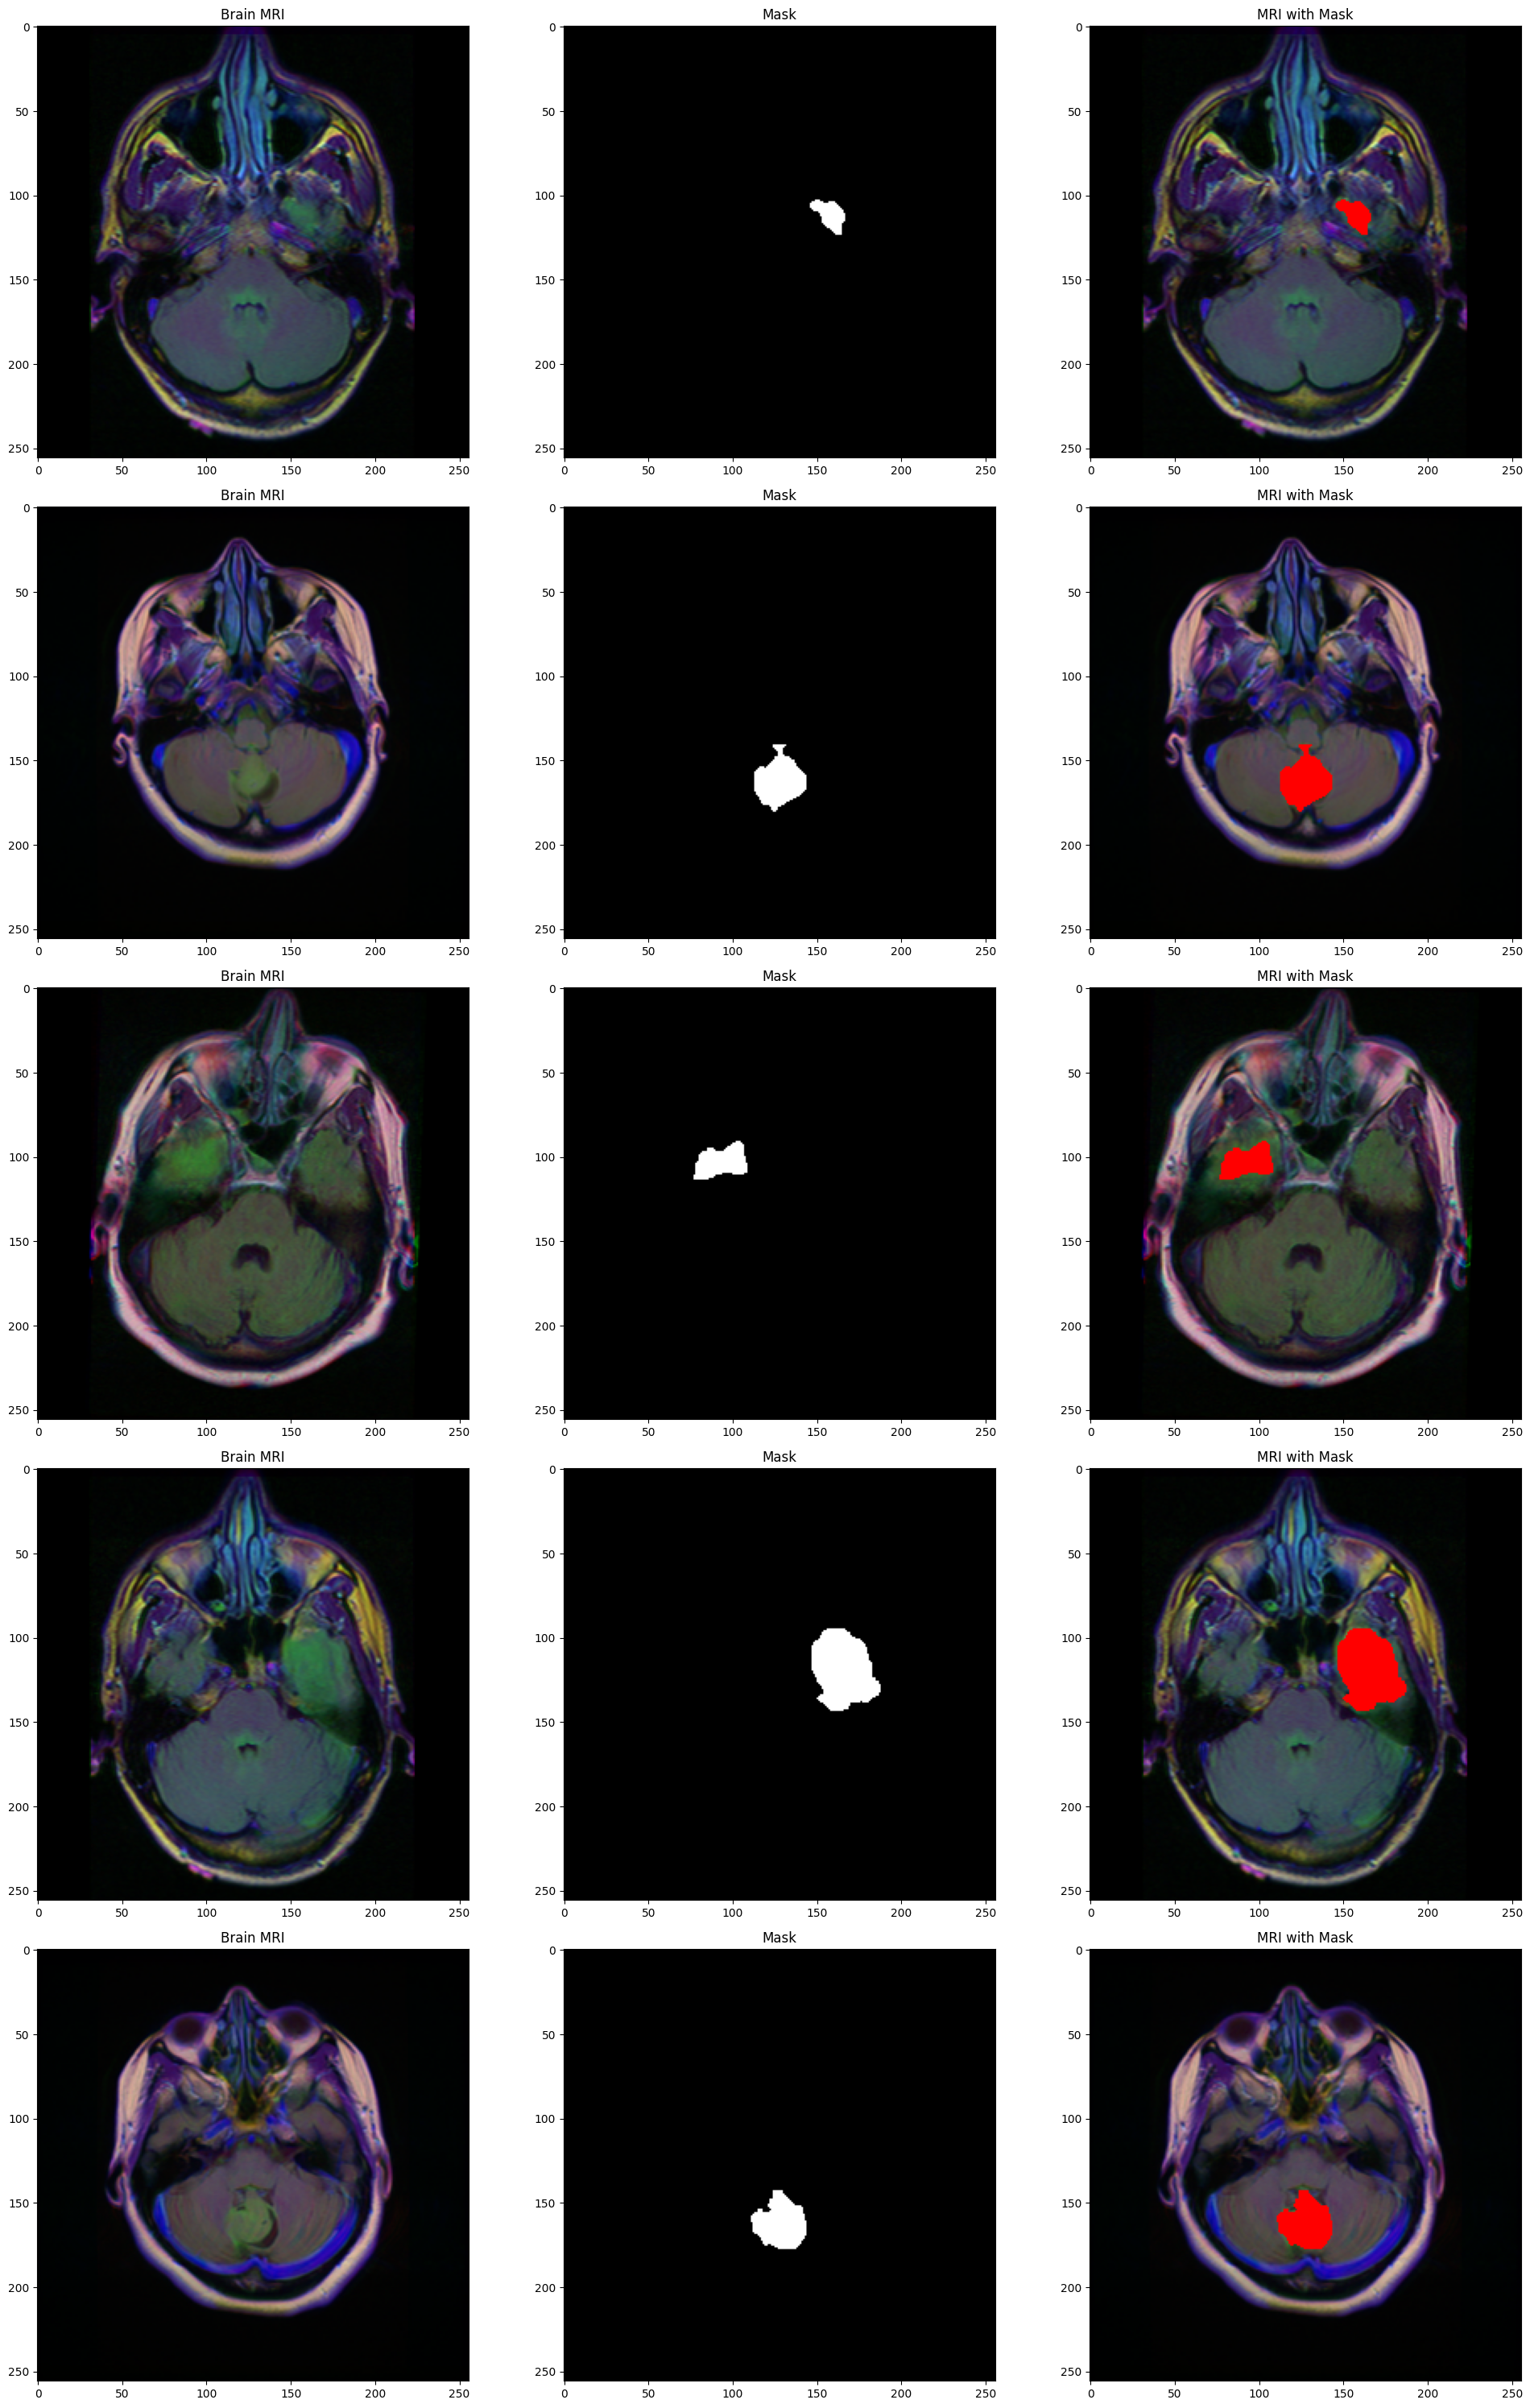

In [ ]:
count = 0
fig, axes = plt.subplots(5, 3, figsize = (20, 30))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 5:

    img = io.imread(folder_path+brain_df.image_path[i])
    axes[count][0].set_title('Brain MRI')
    axes[count][0].imshow(img)

    mask = io.imread(folder_path+brain_df.mask_path[i])
    axes[count][1].set_title('Mask')
    axes[count][1].imshow(mask, cmap='gray')

    img[mask == 255] = (255, 0, 0) # make brain tumor red on original brain MRI
    axes[count][2].set_title('MRI with Mask')
    axes[count][2].imshow(img)
    count+=1
fig.tight_layout()

 ## Model to detect if there's a brain tumor


In [ ]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
brain_df.info()
# need to convert 'mask' column to str type,
# otherwise Image data generator will give you an error, if you want to use 'categorical mode'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
image_data_gen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)
test_data_gen = ImageDataGenerator(rescale=1./255.)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
batch = 16

In [ ]:
train_gen = image_data_gen.flow_from_dataframe(dataframe=train,
                                               directory='/content/drive/MyDrive/kaggle_3m',
                                               x_col='image_path', y_col='mask',
                                               subset='training',
                                               batch_size=batch,
                                               shuffle=True,
                                               class_mode='categorical',
                                               target_size=(256, 256))
val_gen = image_data_gen.flow_from_dataframe(dataframe=train,
                                               directory='/content/drive/MyDrive/kaggle_3m',
                                               x_col='image_path', y_col='mask',
                                               subset='validation',
                                               batch_size=batch,
                                               shuffle=True,
                                               class_mode='categorical',
                                               target_size=(256, 256))
test_gen = test_data_gen.flow_from_dataframe(dataframe=test,
                                               directory='/content/drive/MyDrive/kaggle_3m',
                                               x_col='image_path', y_col='mask',
                                               batch_size=batch,
                                               shuffle=False,
                                               class_mode='categorical',
                                               target_size=(256, 256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
test['mask'].value_counts()

mask
0    366
1    224
Name: count, dtype: int64

In [ ]:
resnet = ResNet50(include_top=False, input_tensor=Input((256, 256, 3)))
#resnet.summary()

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
def freeze_or_tune(tune=True):
  if tune:
    resnet.trainable = True
  else:
    resnet.trainable = False

In [ ]:
# optional
freeze_or_tune(True)

In [ ]:
# for Fine tuning (not the whole resnet will be tuned)
for i in range(len(resnet.layers)):
  if resnet.layers[i].name.startswith('conv5') or resnet.layers[i].name.startswith('conv4') or resnet.layers[i].name.startswith('conv3'):
    resnet.layers[i].trainable = True
  else:
    resnet.layers[i].trainable = False

In [ ]:
# look at this table and make sure that necessary layers trainable or not
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
df = pd.DataFrame(layers, columns=['layer', 'name', 'is_trainable'])
df[df['is_trainable']==True]

,layer,name,is_trainable
39,<keras.src.layers.convolutional.conv2d.Conv2D ...,conv3_block1_1_conv,True
40,<keras.src.layers.normalization.batch_normaliz...,conv3_block1_1_bn,True
41,<keras.src.layers.core.activation.Activation o...,conv3_block1_1_relu,True
42,<keras.src.layers.convolutional.conv2d.Conv2D ...,conv3_block1_2_conv,True
43,<keras.src.layers.normalization.batch_normaliz...,conv3_block1_2_bn,True
...,...,...,...
170,<keras.src.layers.core.activation.Activation o...,conv5_block3_2_relu,True
171,<keras.src.layers.convolutional.conv2d.Conv2D ...,conv5_block3_3_conv,True
172,<keras.src.layers.normalization.batch_normaliz...,conv5_block3_3_bn,True
173,<keras.src.layers.merging.add.Add object at 0x...,conv5_block3_add,True


In [ ]:
# build model
X = resnet.output
X = AveragePooling2D((4, 4))(X)
X = Flatten(name='flatten')(X)
X = Dense(256, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(256, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(256, activation='relu')(X)
X = Dropout(0.3)(X)
output = Dense(2, activation='softmax')(X)
model = Model(inputs=resnet.input, outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics= ['accuracy'])

In [ ]:
length_of_train_gen = train_gen.n
print("Length of train_gen:", length_of_train_gen)

Length of train_gen: 2839


In [ ]:
train_gen

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
path_checkpoint = '/content/drive/MyDrive/models/model_checkpoint_{epoch:02d}.h5'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_best_only=True,save_freq=5)

In [ ]:
history = model.fit(train_gen, steps_per_epoch=train_gen.n // batch,
                    epochs=20, validation_data=val_gen,
                    validation_steps=val_gen.n // batch,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/20
  4/177 [..............................] - ETA: 5:35 - loss: 0.7713 - accuracy: 0.5312

  9/177 [>.............................] - ETA: 12:22 - loss: 0.6480 - accuracy: 0.6319

 14/177 [=>............................] - ETA: 13:30 - loss: 0.6111 - accuracy: 0.6518

 19/177 [==>...........................] - ETA: 23:36 - loss: 0.6025 - accuracy: 0.6678

 24/177 [===>..........................] - ETA: 24:26 - loss: 0.5899 - accuracy: 0.6875

 29/177 [===>..........................] - ETA: 26:03 - loss: 0.5823 - accuracy: 0.6961

 34/177 [====>.........................] - ETA: 23:35 - loss: 0.5643 - accuracy: 0.7169

 39/177 [=====>........................] - ETA: 25:19 - loss: 0.5674 - accuracy: 0.7212

 44/177 [======>.......................] - ETA: 23:06 - loss: 0.5566 - accuracy: 0.7202

 49/177 [=======>......................] - ETA: 21:17 - loss: 0.5533 - accuracy: 0.7245

 54/177 [========>.....................] - ETA: 19:42 - loss: 0.5377 - accuracy: 0.7338

 59/177 [=========>....................] - ETA: 18:19 - loss: 0.5285 - accuracy: 0.7394

 64/177 [=========>....................] - ETA: 17:04 - loss: 0.5210 - accuracy: 0.7412

 69/177 [==========>...................] - ETA: 16:37 - loss: 0.5235 - accuracy: 0.7437

 74/177 [===========>..................] - ETA: 15:28 - loss: 0.5144 - accuracy: 0.7458

 79/177 [============>.................] - ETA: 14:50 - loss: 0.5216 - accuracy: 0.7421

 84/177 [=============>................] - ETA: 14:16 - loss: 0.5150 - accuracy: 0.7440

 89/177 [==============>...............] - ETA: 13:15 - loss: 0.5124 - accuracy: 0.7472

 94/177 [==============>...............] - ETA: 12:38 - loss: 0.5081 - accuracy: 0.7520

 99/177 [===============>..............] - ETA: 11:39 - loss: 0.5062 - accuracy: 0.7513

104/177 [================>.............] - ETA: 10:43 - loss: 0.5000 - accuracy: 0.7542

109/177 [=================>............] - ETA: 9:50 - loss: 0.4911 - accuracy: 0.7586 

114/177 [==================>...........] - ETA: 9:00 - loss: 0.4854 - accuracy: 0.7610

119/177 [===================>..........] - ETA: 8:12 - loss: 0.4789 - accuracy: 0.7668

124/177 [====================>.........] - ETA: 7:25 - loss: 0.4727 - accuracy: 0.7707

129/177 [====================>.........] - ETA: 6:39 - loss: 0.4705 - accuracy: 0.7728

134/177 [=====================>........] - ETA: 6:13 - loss: 0.4640 - accuracy: 0.7766

139/177 [======================>.......] - ETA: 5:26 - loss: 0.4600 - accuracy: 0.7788

144/177 [=======================>......] - ETA: 4:40 - loss: 0.4612 - accuracy: 0.7817

149/177 [========================>.....] - ETA: 4:09 - loss: 0.4540 - accuracy: 0.7836

154/177 [=========================>....] - ETA: 3:26 - loss: 0.4483 - accuracy: 0.7849

159/177 [=========================>....] - ETA: 2:49 - loss: 0.4477 - accuracy: 0.7873

164/177 [==========================>...] - ETA: 2:07 - loss: 0.4406 - accuracy: 0.7912

169/177 [===========================>..] - ETA: 1:20 - loss: 0.4385 - accuracy: 0.7929

174/177 [============================>.] - ETA: 29s - loss: 0.4389 - accuracy: 0.7939

177/177 [==============================] - 1969s 11s/step - loss: 0.4344 - accuracy: 0.7963 - val_loss: 2.0992 - val_accuracy: 0.6613
Epoch 2/20
  2/177 [..............................] - ETA: 31s - loss: 0.4831 - accuracy: 0.7812 

  7/177 [>.............................] - ETA: 29s - loss: 0.3912 - accuracy: 0.8125

 12/177 [=>............................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8333

 17/177 [=>............................] - ETA: 27s - loss: 0.3562 - accuracy: 0.8419

 22/177 [==>...........................] - ETA: 26s - loss: 0.3235 - accuracy: 0.8523

 27/177 [===>..........................] - ETA: 25s - loss: 0.3019 - accuracy: 0.8657

 32/177 [====>.........................] - ETA: 24s - loss: 0.2920 - accuracy: 0.8730

 37/177 [=====>........................] - ETA: 23s - loss: 0.3100 - accuracy: 0.8682

 42/177 [======>.......................] - ETA: 23s - loss: 0.3148 - accuracy: 0.8661

 47/177 [======>.......................] - ETA: 22s - loss: 0.3107 - accuracy: 0.8684

 52/177 [=======>......................] - ETA: 21s - loss: 0.3131 - accuracy: 0.8702

 57/177 [========>.....................] - ETA: 20s - loss: 0.3296 - accuracy: 0.8662

 62/177 [=========>....................] - ETA: 19s - loss: 0.3287 - accuracy: 0.8629

 67/177 [==========>...................] - ETA: 19s - loss: 0.3239 - accuracy: 0.8675

 72/177 [===========>..................] - ETA: 18s - loss: 0.3241 - accuracy: 0.8698

 77/177 [============>.................] - ETA: 17s - loss: 0.3164 - accuracy: 0.8749

 82/177 [============>.................] - ETA: 16s - loss: 0.3074 - accuracy: 0.8764

 87/177 [=============>................] - ETA: 15s - loss: 0.2980 - accuracy: 0.8807

 92/177 [==============>...............] - ETA: 14s - loss: 0.2911 - accuracy: 0.8852

 97/177 [===============>..............] - ETA: 13s - loss: 0.2872 - accuracy: 0.8872

102/177 [================>.............] - ETA: 13s - loss: 0.2861 - accuracy: 0.8885

107/177 [=================>............] - ETA: 12s - loss: 0.2856 - accuracy: 0.8884

112/177 [=================>............] - ETA: 11s - loss: 0.2814 - accuracy: 0.8901

117/177 [==================>...........] - ETA: 10s - loss: 0.2794 - accuracy: 0.8889

122/177 [===================>..........] - ETA: 9s - loss: 0.2771 - accuracy: 0.8909

127/177 [====================>.........] - ETA: 8s - loss: 0.2758 - accuracy: 0.8903

132/177 [=====================>........] - ETA: 7s - loss: 0.2719 - accuracy: 0.8921

137/177 [======================>.......] - ETA: 6s - loss: 0.2778 - accuracy: 0.8919

142/177 [=======================>......] - ETA: 6s - loss: 0.2782 - accuracy: 0.8917

147/177 [=======================>......] - ETA: 5s - loss: 0.2739 - accuracy: 0.8942

152/177 [========================>.....] - ETA: 4s - loss: 0.2794 - accuracy: 0.8910

157/177 [=========================>....] - ETA: 3s - loss: 0.2800 - accuracy: 0.8897

162/177 [==========================>...] - ETA: 2s - loss: 0.2852 - accuracy: 0.8881

167/177 [===========================>..] - ETA: 1s - loss: 0.2844 - accuracy: 0.8877

172/177 [============================>.] - ETA: 0s - loss: 0.2847 - accuracy: 0.8870

177/177 [==============================] - 34s 189ms/step - loss: 0.2880 - accuracy: 0.8870 - val_loss: 0.9653 - val_accuracy: 0.7460
Epoch 3/20


  5/177 [..............................] - ETA: 29s - loss: 0.2439 - accuracy: 0.9375

 10/177 [>.............................] - ETA: 28s - loss: 0.2311 - accuracy: 0.9250

 15/177 [=>............................] - ETA: 27s - loss: 0.2067 - accuracy: 0.9333

 20/177 [==>...........................] - ETA: 26s - loss: 0.2042 - accuracy: 0.9281

 25/177 [===>..........................] - ETA: 26s - loss: 0.2127 - accuracy: 0.9225

 30/177 [====>.........................] - ETA: 25s - loss: 0.2024 - accuracy: 0.9250

 35/177 [====>.........................] - ETA: 25s - loss: 0.1982 - accuracy: 0.9286

 40/177 [=====>........................] - ETA: 24s - loss: 0.2117 - accuracy: 0.9250

 45/177 [======>.......................] - ETA: 23s - loss: 0.2158 - accuracy: 0.9250

 50/177 [=======>......................] - ETA: 22s - loss: 0.2190 - accuracy: 0.9237

 55/177 [========>.....................] - ETA: 21s - loss: 0.2270 - accuracy: 0.9193

 60/177 [=========>....................] - ETA: 20s - loss: 0.2265 - accuracy: 0.9177

 65/177 [==========>...................] - ETA: 19s - loss: 0.2187 - accuracy: 0.9202

 70/177 [==========>...................] - ETA: 18s - loss: 0.2164 - accuracy: 0.9223

 75/177 [===========>..................] - ETA: 17s - loss: 0.2159 - accuracy: 0.9208

 80/177 [============>.................] - ETA: 16s - loss: 0.2115 - accuracy: 0.9227

 85/177 [=============>................] - ETA: 15s - loss: 0.2080 - accuracy: 0.9235

 90/177 [==============>...............] - ETA: 14s - loss: 0.2108 - accuracy: 0.9243

 95/177 [===============>..............] - ETA: 14s - loss: 0.2077 - accuracy: 0.9263

100/177 [===============>..............] - ETA: 13s - loss: 0.2105 - accuracy: 0.9256

105/177 [================>.............] - ETA: 12s - loss: 0.2141 - accuracy: 0.9244

110/177 [=================>............] - ETA: 11s - loss: 0.2127 - accuracy: 0.9250

115/177 [==================>...........] - ETA: 10s - loss: 0.2128 - accuracy: 0.9239

120/177 [===================>..........] - ETA: 9s - loss: 0.2137 - accuracy: 0.9234 

125/177 [====================>.........] - ETA: 8s - loss: 0.2116 - accuracy: 0.9225

130/177 [=====================>........] - ETA: 8s - loss: 0.2086 - accuracy: 0.9226

135/177 [=====================>........] - ETA: 7s - loss: 0.2081 - accuracy: 0.9231

140/177 [======================>.......] - ETA: 6s - loss: 0.2056 - accuracy: 0.9237

145/177 [=======================>......] - ETA: 5s - loss: 0.2101 - accuracy: 0.9233

150/177 [========================>.....] - ETA: 4s - loss: 0.2091 - accuracy: 0.9242

155/177 [=========================>....] - ETA: 3s - loss: 0.2087 - accuracy: 0.9250

160/177 [==========================>...] - ETA: 2s - loss: 0.2061 - accuracy: 0.9258

165/177 [==========================>...] - ETA: 2s - loss: 0.2072 - accuracy: 0.9255

170/177 [===========================>..] - ETA: 1s - loss: 0.2092 - accuracy: 0.9248

175/177 [============================>.] - ETA: 0s - loss: 0.2093 - accuracy: 0.9258

177/177 [==============================] - 33s 189ms/step - loss: 0.2082 - accuracy: 0.9263 - val_loss: 0.3859 - val_accuracy: 0.7944
Epoch 4/20
  3/177 [..............................] - ETA: 30s - loss: 0.2322 - accuracy: 0.9375

  8/177 [>.............................] - ETA: 28s - loss: 0.2288 - accuracy: 0.9453

 13/177 [=>............................] - ETA: 27s - loss: 0.2207 - accuracy: 0.9471

 18/177 [==>...........................] - ETA: 27s - loss: 0.1943 - accuracy: 0.9514

 23/177 [==>...........................] - ETA: 26s - loss: 0.2017 - accuracy: 0.9511

 28/177 [===>..........................] - ETA: 25s - loss: 0.2007 - accuracy: 0.9464

 33/177 [====>.........................] - ETA: 25s - loss: 0.1821 - accuracy: 0.9527

 38/177 [=====>........................] - ETA: 24s - loss: 0.1768 - accuracy: 0.9523

 43/177 [======>.......................] - ETA: 23s - loss: 0.1717 - accuracy: 0.9491

 48/177 [=======>......................] - ETA: 22s - loss: 0.1707 - accuracy: 0.9479

 53/177 [=======>......................] - ETA: 21s - loss: 0.1629 - accuracy: 0.9493

 58/177 [========>.....................] - ETA: 20s - loss: 0.1659 - accuracy: 0.9472

 63/177 [=========>....................] - ETA: 19s - loss: 0.1581 - accuracy: 0.9504

 68/177 [==========>...................] - ETA: 18s - loss: 0.1594 - accuracy: 0.9504

 73/177 [===========>..................] - ETA: 17s - loss: 0.1636 - accuracy: 0.9486

 78/177 [============>.................] - ETA: 16s - loss: 0.1608 - accuracy: 0.9479

 83/177 [=============>................] - ETA: 16s - loss: 0.1574 - accuracy: 0.9488

 88/177 [=============>................] - ETA: 15s - loss: 0.1536 - accuracy: 0.9503

 93/177 [==============>...............] - ETA: 14s - loss: 0.1557 - accuracy: 0.9483

 98/177 [===============>..............] - ETA: 13s - loss: 0.1594 - accuracy: 0.9477

103/177 [================>.............] - ETA: 12s - loss: 0.1541 - accuracy: 0.9490

108/177 [=================>............] - ETA: 11s - loss: 0.1605 - accuracy: 0.9473

113/177 [==================>...........] - ETA: 11s - loss: 0.1603 - accuracy: 0.9463

118/177 [===================>..........] - ETA: 10s - loss: 0.1589 - accuracy: 0.9470

123/177 [===================>..........] - ETA: 9s - loss: 0.1568 - accuracy: 0.9482

128/177 [====================>.........] - ETA: 8s - loss: 0.1538 - accuracy: 0.9482

133/177 [=====================>........] - ETA: 7s - loss: 0.1560 - accuracy: 0.9474

138/177 [======================>.......] - ETA: 6s - loss: 0.1572 - accuracy: 0.9475

143/177 [=======================>......] - ETA: 5s - loss: 0.1573 - accuracy: 0.9471

148/177 [========================>.....] - ETA: 5s - loss: 0.1560 - accuracy: 0.9476

153/177 [========================>.....] - ETA: 4s - loss: 0.1561 - accuracy: 0.9475

158/177 [=========================>....] - ETA: 3s - loss: 0.1561 - accuracy: 0.9472

163/177 [==========================>...] - ETA: 2s - loss: 0.1573 - accuracy: 0.9469

168/177 [===========================>..] - ETA: 1s - loss: 0.1583 - accuracy: 0.9470

173/177 [============================>.] - ETA: 0s - loss: 0.1579 - accuracy: 0.9467

177/177 [==============================] - 34s 189ms/step - loss: 0.1598 - accuracy: 0.9451 - val_loss: 0.1939 - val_accuracy: 0.9214
Epoch 5/20
  1/177 [..............................] - ETA: 56s - loss: 0.2415 - accuracy: 0.8750

  6/177 [>.............................] - ETA: 28s - loss: 0.1127 - accuracy: 0.9688

 11/177 [>.............................] - ETA: 28s - loss: 0.0852 - accuracy: 0.9830

 16/177 [=>............................] - ETA: 27s - loss: 0.1391 - accuracy: 0.9609

 21/177 [==>...........................] - ETA: 27s - loss: 0.1423 - accuracy: 0.9554

 26/177 [===>..........................] - ETA: 26s - loss: 0.1418 - accuracy: 0.9519

 31/177 [====>.........................] - ETA: 25s - loss: 0.1398 - accuracy: 0.9556

 36/177 [=====>........................] - ETA: 24s - loss: 0.1266 - accuracy: 0.9601

 41/177 [=====>........................] - ETA: 23s - loss: 0.1222 - accuracy: 0.9619

 46/177 [======>.......................] - ETA: 22s - loss: 0.1250 - accuracy: 0.9565

 51/177 [=======>......................] - ETA: 21s - loss: 0.1184 - accuracy: 0.9583

 56/177 [========>.....................] - ETA: 21s - loss: 0.1112 - accuracy: 0.9621

 61/177 [=========>....................] - ETA: 20s - loss: 0.1174 - accuracy: 0.9600

 66/177 [==========>...................] - ETA: 19s - loss: 0.1166 - accuracy: 0.9602

 71/177 [===========>..................] - ETA: 18s - loss: 0.1155 - accuracy: 0.9604

 76/177 [===========>..................] - ETA: 17s - loss: 0.1133 - accuracy: 0.9605

 81/177 [============>.................] - ETA: 16s - loss: 0.1183 - accuracy: 0.9591

 86/177 [=============>................] - ETA: 15s - loss: 0.1179 - accuracy: 0.9586

 91/177 [==============>...............] - ETA: 14s - loss: 0.1224 - accuracy: 0.9560

 96/177 [===============>..............] - ETA: 14s - loss: 0.1252 - accuracy: 0.9557

101/177 [================>.............] - ETA: 13s - loss: 0.1235 - accuracy: 0.9554

106/177 [================>.............] - ETA: 12s - loss: 0.1246 - accuracy: 0.9552

111/177 [=================>............] - ETA: 11s - loss: 0.1243 - accuracy: 0.9544

116/177 [==================>...........] - ETA: 10s - loss: 0.1286 - accuracy: 0.9531

121/177 [===================>..........] - ETA: 9s - loss: 0.1259 - accuracy: 0.9545 

126/177 [====================>.........] - ETA: 8s - loss: 0.1250 - accuracy: 0.9559

131/177 [=====================>........] - ETA: 8s - loss: 0.1241 - accuracy: 0.9561

136/177 [======================>.......] - ETA: 7s - loss: 0.1212 - accuracy: 0.9573

141/177 [======================>.......] - ETA: 6s - loss: 0.1178 - accuracy: 0.9588

146/177 [=======================>......] - ETA: 5s - loss: 0.1158 - accuracy: 0.9598

151/177 [========================>.....] - ETA: 4s - loss: 0.1162 - accuracy: 0.9599

156/177 [=========================>....] - ETA: 3s - loss: 0.1172 - accuracy: 0.9603

161/177 [==========================>...] - ETA: 2s - loss: 0.1201 - accuracy: 0.9591

166/177 [===========================>..] - ETA: 1s - loss: 0.1221 - accuracy: 0.9581

171/177 [===========================>..] - ETA: 1s - loss: 0.1267 - accuracy: 0.9545

176/177 [============================>.] - ETA: 0s - loss: 0.1284 - accuracy: 0.9537

177/177 [==============================] - 34s 192ms/step - loss: 0.1282 - accuracy: 0.9536 - val_loss: 0.3641 - val_accuracy: 0.8488
Epoch 6/20
  4/177 [..............................] - ETA: 29s - loss: 0.0867 - accuracy: 0.9844

  9/177 [>.............................] - ETA: 28s - loss: 0.0635 - accuracy: 0.9861

 14/177 [=>............................] - ETA: 28s - loss: 0.0691 - accuracy: 0.9777

 19/177 [==>...........................] - ETA: 27s - loss: 0.0686 - accuracy: 0.9763

 24/177 [===>..........................] - ETA: 26s - loss: 0.0881 - accuracy: 0.9733

 29/177 [===>..........................] - ETA: 25s - loss: 0.0856 - accuracy: 0.9758

 34/177 [====>.........................] - ETA: 24s - loss: 0.0953 - accuracy: 0.9738

 39/177 [=====>........................] - ETA: 23s - loss: 0.0985 - accuracy: 0.9740

 44/177 [======>.......................] - ETA: 22s - loss: 0.0947 - accuracy: 0.9741

 49/177 [=======>......................] - ETA: 21s - loss: 0.0964 - accuracy: 0.9742

 54/177 [========>.....................] - ETA: 21s - loss: 0.0927 - accuracy: 0.9743

 59/177 [=========>....................] - ETA: 20s - loss: 0.0950 - accuracy: 0.9733

 64/177 [=========>....................] - ETA: 19s - loss: 0.0960 - accuracy: 0.9734

 69/177 [==========>...................] - ETA: 18s - loss: 0.0982 - accuracy: 0.9717

 74/177 [===========>..................] - ETA: 17s - loss: 0.1009 - accuracy: 0.9702

 79/177 [============>.................] - ETA: 16s - loss: 0.1000 - accuracy: 0.9705

 84/177 [=============>................] - ETA: 15s - loss: 0.0987 - accuracy: 0.9715

 89/177 [==============>...............] - ETA: 15s - loss: 0.0997 - accuracy: 0.9703

 94/177 [==============>...............] - ETA: 14s - loss: 0.0966 - accuracy: 0.9706

 99/177 [===============>..............] - ETA: 13s - loss: 0.0948 - accuracy: 0.9708

104/177 [================>.............] - ETA: 12s - loss: 0.0940 - accuracy: 0.9710

109/177 [=================>............] - ETA: 11s - loss: 0.0966 - accuracy: 0.9689

114/177 [==================>...........] - ETA: 10s - loss: 0.0966 - accuracy: 0.9691

119/177 [===================>..........] - ETA: 10s - loss: 0.0959 - accuracy: 0.9694

124/177 [====================>.........] - ETA: 9s - loss: 0.1036 - accuracy: 0.9681

129/177 [====================>.........] - ETA: 8s - loss: 0.1021 - accuracy: 0.9684

134/177 [=====================>........] - ETA: 7s - loss: 0.1037 - accuracy: 0.9681

139/177 [======================>.......] - ETA: 6s - loss: 0.1023 - accuracy: 0.9684

144/177 [=======================>......] - ETA: 5s - loss: 0.1033 - accuracy: 0.9682

149/177 [========================>.....] - ETA: 4s - loss: 0.1021 - accuracy: 0.9688

154/177 [=========================>....] - ETA: 3s - loss: 0.1038 - accuracy: 0.9682

159/177 [=========================>....] - ETA: 3s - loss: 0.1026 - accuracy: 0.9684

164/177 [==========================>...] - ETA: 2s - loss: 0.1028 - accuracy: 0.9683

169/177 [===========================>..] - ETA: 1s - loss: 0.1063 - accuracy: 0.9685

174/177 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.9686

177/177 [==============================] - 33s 188ms/step - loss: 0.1066 - accuracy: 0.9685 - val_loss: 0.2437 - val_accuracy: 0.8810
Epoch 7/20
  2/177 [..............................] - ETA: 30s - loss: 0.0638 - accuracy: 0.9688

  7/177 [>.............................] - ETA: 29s - loss: 0.0509 - accuracy: 0.9821

 12/177 [=>............................] - ETA: 28s - loss: 0.0483 - accuracy: 0.9792

 17/177 [=>............................] - ETA: 27s - loss: 0.0537 - accuracy: 0.9779

 22/177 [==>...........................] - ETA: 26s - loss: 0.0504 - accuracy: 0.9801

 27/177 [===>..........................] - ETA: 25s - loss: 0.0678 - accuracy: 0.9769

 32/177 [====>.........................] - ETA: 24s - loss: 0.0628 - accuracy: 0.9785

 37/177 [=====>........................] - ETA: 23s - loss: 0.0592 - accuracy: 0.9797

 42/177 [======>.......................] - ETA: 23s - loss: 0.0650 - accuracy: 0.9792

 47/177 [======>.......................] - ETA: 22s - loss: 0.0748 - accuracy: 0.9774

 52/177 [=======>......................] - ETA: 21s - loss: 0.0804 - accuracy: 0.9748

 57/177 [========>.....................] - ETA: 20s - loss: 0.0853 - accuracy: 0.9726

 62/177 [=========>....................] - ETA: 19s - loss: 0.0889 - accuracy: 0.9708

 67/177 [==========>...................] - ETA: 19s - loss: 0.0934 - accuracy: 0.9711

 72/177 [===========>..................] - ETA: 18s - loss: 0.0917 - accuracy: 0.9705

 77/177 [============>.................] - ETA: 17s - loss: 0.0974 - accuracy: 0.9692

 82/177 [============>.................] - ETA: 16s - loss: 0.0973 - accuracy: 0.9695

 87/177 [=============>................] - ETA: 15s - loss: 0.0998 - accuracy: 0.9677

 92/177 [==============>...............] - ETA: 14s - loss: 0.0991 - accuracy: 0.9667

 97/177 [===============>..............] - ETA: 13s - loss: 0.0967 - accuracy: 0.9671

102/177 [================>.............] - ETA: 12s - loss: 0.0947 - accuracy: 0.9675

107/177 [=================>............] - ETA: 12s - loss: 0.0935 - accuracy: 0.9685

112/177 [=================>............] - ETA: 11s - loss: 0.0942 - accuracy: 0.9693

117/177 [==================>...........] - ETA: 10s - loss: 0.0917 - accuracy: 0.9706

122/177 [===================>..........] - ETA: 9s - loss: 0.0906 - accuracy: 0.9701

127/177 [====================>.........] - ETA: 8s - loss: 0.0908 - accuracy: 0.9703

132/177 [=====================>........] - ETA: 7s - loss: 0.0891 - accuracy: 0.9710

137/177 [======================>.......] - ETA: 6s - loss: 0.0886 - accuracy: 0.9707

142/177 [=======================>......] - ETA: 6s - loss: 0.0867 - accuracy: 0.9713

147/177 [=======================>......] - ETA: 5s - loss: 0.0914 - accuracy: 0.9710

152/177 [========================>.....] - ETA: 4s - loss: 0.0931 - accuracy: 0.9703

157/177 [=========================>....] - ETA: 3s - loss: 0.0932 - accuracy: 0.9708

162/177 [==========================>...] - ETA: 2s - loss: 0.0932 - accuracy: 0.9706

167/177 [===========================>..] - ETA: 1s - loss: 0.0945 - accuracy: 0.9711

172/177 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9708

177/177 [==============================] - 33s 187ms/step - loss: 0.0940 - accuracy: 0.9706 - val_loss: 0.2436 - val_accuracy: 0.8891
Epoch 8/20


  5/177 [..............................] - ETA: 29s - loss: 0.0525 - accuracy: 0.9625

 10/177 [>.............................] - ETA: 28s - loss: 0.0588 - accuracy: 0.9625

 15/177 [=>............................] - ETA: 27s - loss: 0.0700 - accuracy: 0.9708

 20/177 [==>...........................] - ETA: 26s - loss: 0.0634 - accuracy: 0.9750

 25/177 [===>..........................] - ETA: 25s - loss: 0.0604 - accuracy: 0.9775

 30/177 [====>.........................] - ETA: 24s - loss: 0.0539 - accuracy: 0.9812

 35/177 [====>.........................] - ETA: 23s - loss: 0.0482 - accuracy: 0.9839

 40/177 [=====>........................] - ETA: 23s - loss: 0.0479 - accuracy: 0.9828

 45/177 [======>.......................] - ETA: 22s - loss: 0.0593 - accuracy: 0.9819

 50/177 [=======>......................] - ETA: 21s - loss: 0.0590 - accuracy: 0.9812

 55/177 [========>.....................] - ETA: 21s - loss: 0.0620 - accuracy: 0.9784

 60/177 [=========>....................] - ETA: 20s - loss: 0.0612 - accuracy: 0.9802

 65/177 [==========>...................] - ETA: 19s - loss: 0.0682 - accuracy: 0.9798

 70/177 [==========>...................] - ETA: 18s - loss: 0.0641 - accuracy: 0.9812

 75/177 [===========>..................] - ETA: 17s - loss: 0.0713 - accuracy: 0.9775

 80/177 [============>.................] - ETA: 16s - loss: 0.0727 - accuracy: 0.9773

 85/177 [=============>................] - ETA: 15s - loss: 0.0750 - accuracy: 0.9757

 90/177 [==============>...............] - ETA: 14s - loss: 0.0826 - accuracy: 0.9743

 95/177 [===============>..............] - ETA: 14s - loss: 0.0843 - accuracy: 0.9730

100/177 [===============>..............] - ETA: 13s - loss: 0.0842 - accuracy: 0.9731

105/177 [================>.............] - ETA: 12s - loss: 0.0843 - accuracy: 0.9732

110/177 [=================>............] - ETA: 11s - loss: 0.0826 - accuracy: 0.9737

115/177 [==================>...........] - ETA: 10s - loss: 0.0808 - accuracy: 0.9749

120/177 [===================>..........] - ETA: 9s - loss: 0.0816 - accuracy: 0.9738

125/177 [====================>.........] - ETA: 8s - loss: 0.0791 - accuracy: 0.9749

130/177 [=====================>........] - ETA: 8s - loss: 0.0782 - accuracy: 0.9749

135/177 [=====================>........] - ETA: 7s - loss: 0.0776 - accuracy: 0.9749

140/177 [======================>.......] - ETA: 6s - loss: 0.0843 - accuracy: 0.9722

145/177 [=======================>......] - ETA: 5s - loss: 0.0856 - accuracy: 0.9719

150/177 [========================>.....] - ETA: 4s - loss: 0.0844 - accuracy: 0.9728

155/177 [=========================>....] - ETA: 3s - loss: 0.0837 - accuracy: 0.9733

160/177 [==========================>...] - ETA: 2s - loss: 0.0857 - accuracy: 0.9730

165/177 [==========================>...] - ETA: 2s - loss: 0.0863 - accuracy: 0.9726

170/177 [===========================>..] - ETA: 1s - loss: 0.0847 - accuracy: 0.9734

175/177 [============================>.] - ETA: 0s - loss: 0.0882 - accuracy: 0.9728

177/177 [==============================] - 33s 187ms/step - loss: 0.0874 - accuracy: 0.9731 - val_loss: 0.2318 - val_accuracy: 0.8891
Epoch 9/20
  3/177 [..............................] - ETA: 30s - loss: 0.0270 - accuracy: 1.0000

  8/177 [>.............................] - ETA: 28s - loss: 0.0315 - accuracy: 0.9922

 13/177 [=>............................] - ETA: 27s - loss: 0.0390 - accuracy: 0.9856

 18/177 [==>...........................] - ETA: 26s - loss: 0.0358 - accuracy: 0.9896

 23/177 [==>...........................] - ETA: 26s - loss: 0.0339 - accuracy: 0.9891

 28/177 [===>..........................] - ETA: 25s - loss: 0.0509 - accuracy: 0.9844

 33/177 [====>.........................] - ETA: 24s - loss: 0.0727 - accuracy: 0.9848

 38/177 [=====>........................] - ETA: 23s - loss: 0.0817 - accuracy: 0.9803

 43/177 [======>.......................] - ETA: 23s - loss: 0.0816 - accuracy: 0.9767

 48/177 [=======>......................] - ETA: 22s - loss: 0.0867 - accuracy: 0.9740

 53/177 [=======>......................] - ETA: 21s - loss: 0.0883 - accuracy: 0.9729

 58/177 [========>.....................] - ETA: 20s - loss: 0.0871 - accuracy: 0.9731

 63/177 [=========>....................] - ETA: 19s - loss: 0.0829 - accuracy: 0.9752

 68/177 [==========>...................] - ETA: 18s - loss: 0.0792 - accuracy: 0.9770

 73/177 [===========>..................] - ETA: 17s - loss: 0.0759 - accuracy: 0.9777

 78/177 [============>.................] - ETA: 16s - loss: 0.0723 - accuracy: 0.9792

 83/177 [=============>................] - ETA: 16s - loss: 0.0723 - accuracy: 0.9782

 88/177 [=============>................] - ETA: 15s - loss: 0.0703 - accuracy: 0.9780

 93/177 [==============>...............] - ETA: 14s - loss: 0.0675 - accuracy: 0.9792

 98/177 [===============>..............] - ETA: 13s - loss: 0.0666 - accuracy: 0.9790

103/177 [================>.............] - ETA: 12s - loss: 0.0639 - accuracy: 0.9800

108/177 [=================>............] - ETA: 11s - loss: 0.0619 - accuracy: 0.9808

113/177 [==================>...........] - ETA: 10s - loss: 0.0595 - accuracy: 0.9817

118/177 [===================>..........] - ETA: 10s - loss: 0.0620 - accuracy: 0.9803

123/177 [===================>..........] - ETA: 9s - loss: 0.0599 - accuracy: 0.9811

128/177 [====================>.........] - ETA: 8s - loss: 0.0631 - accuracy: 0.9804

133/177 [=====================>........] - ETA: 7s - loss: 0.0631 - accuracy: 0.9802

138/177 [======================>.......] - ETA: 6s - loss: 0.0677 - accuracy: 0.9791

143/177 [=======================>......] - ETA: 5s - loss: 0.0703 - accuracy: 0.9776

148/177 [========================>.....] - ETA: 4s - loss: 0.0716 - accuracy: 0.9775

153/177 [========================>.....] - ETA: 4s - loss: 0.0710 - accuracy: 0.9779

158/177 [=========================>....] - ETA: 3s - loss: 0.0709 - accuracy: 0.9774

163/177 [==========================>...] - ETA: 2s - loss: 0.0697 - accuracy: 0.9777

168/177 [===========================>..] - ETA: 1s - loss: 0.0712 - accuracy: 0.9769

173/177 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9772

177/177 [==============================] - 34s 189ms/step - loss: 0.0714 - accuracy: 0.9770 - val_loss: 0.1300 - val_accuracy: 0.9597
Epoch 10/20
  1/177 [..............................] - ETA: 49s - loss: 0.0177 - accuracy: 1.0000

  6/177 [>.............................] - ETA: 30s - loss: 0.0195 - accuracy: 1.0000

 11/177 [>.............................] - ETA: 28s - loss: 0.0292 - accuracy: 0.9943

 16/177 [=>............................] - ETA: 27s - loss: 0.0265 - accuracy: 0.9922

 21/177 [==>...........................] - ETA: 26s - loss: 0.0419 - accuracy: 0.9851

 26/177 [===>..........................] - ETA: 26s - loss: 0.0423 - accuracy: 0.9808

 31/177 [====>.........................] - ETA: 25s - loss: 0.0434 - accuracy: 0.9819

 36/177 [=====>........................] - ETA: 24s - loss: 0.0406 - accuracy: 0.9844

 41/177 [=====>........................] - ETA: 23s - loss: 0.0502 - accuracy: 0.9802

 46/177 [======>.......................] - ETA: 22s - loss: 0.0458 - accuracy: 0.9823

 51/177 [=======>......................] - ETA: 21s - loss: 0.0429 - accuracy: 0.9841

 56/177 [========>.....................] - ETA: 20s - loss: 0.0407 - accuracy: 0.9855

 61/177 [=========>....................] - ETA: 19s - loss: 0.0507 - accuracy: 0.9826

 66/177 [==========>...................] - ETA: 19s - loss: 0.0523 - accuracy: 0.9830

 71/177 [===========>..................] - ETA: 18s - loss: 0.0624 - accuracy: 0.9796

 76/177 [===========>..................] - ETA: 17s - loss: 0.0599 - accuracy: 0.9809

 81/177 [============>.................] - ETA: 16s - loss: 0.0589 - accuracy: 0.9806

 86/177 [=============>................] - ETA: 15s - loss: 0.0587 - accuracy: 0.9802

 91/177 [==============>...............] - ETA: 14s - loss: 0.0589 - accuracy: 0.9800

 96/177 [===============>..............] - ETA: 13s - loss: 0.0707 - accuracy: 0.9790

101/177 [================>.............] - ETA: 13s - loss: 0.0716 - accuracy: 0.9788

106/177 [================>.............] - ETA: 12s - loss: 0.0690 - accuracy: 0.9798

111/177 [=================>............] - ETA: 11s - loss: 0.0683 - accuracy: 0.9802

116/177 [==================>...........] - ETA: 10s - loss: 0.0662 - accuracy: 0.9811

121/177 [===================>..........] - ETA: 9s - loss: 0.0662 - accuracy: 0.9813

126/177 [====================>.........] - ETA: 8s - loss: 0.0665 - accuracy: 0.9811

131/177 [=====================>........] - ETA: 7s - loss: 0.0647 - accuracy: 0.9813

136/177 [======================>.......] - ETA: 7s - loss: 0.0630 - accuracy: 0.9820

141/177 [======================>.......] - ETA: 6s - loss: 0.0612 - accuracy: 0.9826

146/177 [=======================>......] - ETA: 5s - loss: 0.0596 - accuracy: 0.9828

151/177 [========================>.....] - ETA: 4s - loss: 0.0639 - accuracy: 0.9826

156/177 [=========================>....] - ETA: 3s - loss: 0.0650 - accuracy: 0.9819

161/177 [==========================>...] - ETA: 2s - loss: 0.0643 - accuracy: 0.9817

166/177 [===========================>..] - ETA: 1s - loss: 0.0633 - accuracy: 0.9822

171/177 [===========================>..] - ETA: 1s - loss: 0.0622 - accuracy: 0.9828

176/177 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9829

177/177 [==============================] - 33s 187ms/step - loss: 0.0619 - accuracy: 0.9830 - val_loss: 0.1544 - val_accuracy: 0.9536
Epoch 11/20
  4/177 [..............................] - ETA: 29s - loss: 0.1466 - accuracy: 0.9531

  9/177 [>.............................] - ETA: 28s - loss: 0.0854 - accuracy: 0.9722

 14/177 [=>............................] - ETA: 27s - loss: 0.0702 - accuracy: 0.9777

 19/177 [==>...........................] - ETA: 26s - loss: 0.1057 - accuracy: 0.9737

 24/177 [===>..........................] - ETA: 25s - loss: 0.1127 - accuracy: 0.9688

 29/177 [===>..........................] - ETA: 24s - loss: 0.1108 - accuracy: 0.9677

 34/177 [====>.........................] - ETA: 24s - loss: 0.1121 - accuracy: 0.9669

 39/177 [=====>........................] - ETA: 23s - loss: 0.1162 - accuracy: 0.9679

 44/177 [======>.......................] - ETA: 22s - loss: 0.1122 - accuracy: 0.9673

 49/177 [=======>......................] - ETA: 21s - loss: 0.1186 - accuracy: 0.9630

 54/177 [========>.....................] - ETA: 20s - loss: 0.1352 - accuracy: 0.9560

 59/177 [=========>....................] - ETA: 20s - loss: 0.1383 - accuracy: 0.9534

 64/177 [=========>....................] - ETA: 19s - loss: 0.1340 - accuracy: 0.9570

 69/177 [==========>...................] - ETA: 18s - loss: 0.1353 - accuracy: 0.9547

 74/177 [===========>..................] - ETA: 17s - loss: 0.1366 - accuracy: 0.9569

 79/177 [============>.................] - ETA: 16s - loss: 0.1327 - accuracy: 0.9581

 84/177 [=============>................] - ETA: 15s - loss: 0.1270 - accuracy: 0.9598

 89/177 [==============>...............] - ETA: 15s - loss: 0.1216 - accuracy: 0.9621

 94/177 [==============>...............] - ETA: 14s - loss: 0.1214 - accuracy: 0.9614

 99/177 [===============>..............] - ETA: 13s - loss: 0.1204 - accuracy: 0.9621

104/177 [================>.............] - ETA: 12s - loss: 0.1167 - accuracy: 0.9633

109/177 [=================>............] - ETA: 11s - loss: 0.1149 - accuracy: 0.9639

114/177 [==================>...........] - ETA: 10s - loss: 0.1119 - accuracy: 0.9649

119/177 [===================>..........] - ETA: 9s - loss: 0.1100 - accuracy: 0.9659 

124/177 [====================>.........] - ETA: 9s - loss: 0.1072 - accuracy: 0.9662

129/177 [====================>.........] - ETA: 8s - loss: 0.1039 - accuracy: 0.9675

134/177 [=====================>........] - ETA: 7s - loss: 0.1003 - accuracy: 0.9688

139/177 [======================>.......] - ETA: 6s - loss: 0.0969 - accuracy: 0.9699

144/177 [=======================>......] - ETA: 5s - loss: 0.0946 - accuracy: 0.9705

149/177 [========================>.....] - ETA: 4s - loss: 0.0923 - accuracy: 0.9715

154/177 [=========================>....] - ETA: 3s - loss: 0.0932 - accuracy: 0.9711

159/177 [=========================>....] - ETA: 3s - loss: 0.0937 - accuracy: 0.9704

164/177 [==========================>...] - ETA: 2s - loss: 0.0923 - accuracy: 0.9709

169/177 [===========================>..] - ETA: 1s - loss: 0.0980 - accuracy: 0.9707

174/177 [============================>.] - ETA: 0s - loss: 0.0970 - accuracy: 0.9705

177/177 [==============================] - 33s 187ms/step - loss: 0.0973 - accuracy: 0.9706 - val_loss: 0.1189 - val_accuracy: 0.9698
Epoch 12/20
  2/177 [..............................] - ETA: 31s - loss: 0.0739 - accuracy: 0.9688

  7/177 [>.............................] - ETA: 30s - loss: 0.0843 - accuracy: 0.9821

 12/177 [=>............................] - ETA: 29s - loss: 0.0619 - accuracy: 0.9896

 17/177 [=>............................] - ETA: 28s - loss: 0.0610 - accuracy: 0.9890

 22/177 [==>...........................] - ETA: 27s - loss: 0.0640 - accuracy: 0.9858

 27/177 [===>..........................] - ETA: 26s - loss: 0.0558 - accuracy: 0.9884

 32/177 [====>.........................] - ETA: 25s - loss: 0.0516 - accuracy: 0.9902

 37/177 [=====>........................] - ETA: 24s - loss: 0.0639 - accuracy: 0.9865

 42/177 [======>.......................] - ETA: 23s - loss: 0.0597 - accuracy: 0.9866

 47/177 [======>.......................] - ETA: 22s - loss: 0.0546 - accuracy: 0.9880

 52/177 [=======>......................] - ETA: 22s - loss: 0.0506 - accuracy: 0.9892

 57/177 [========>.....................] - ETA: 21s - loss: 0.0570 - accuracy: 0.9868

 62/177 [=========>....................] - ETA: 20s - loss: 0.0611 - accuracy: 0.9849

 67/177 [==========>...................] - ETA: 19s - loss: 0.0619 - accuracy: 0.9841

 72/177 [===========>..................] - ETA: 18s - loss: 0.0647 - accuracy: 0.9825

 77/177 [============>.................] - ETA: 17s - loss: 0.0622 - accuracy: 0.9828

 82/177 [============>.................] - ETA: 16s - loss: 0.0594 - accuracy: 0.9839

 87/177 [=============>................] - ETA: 15s - loss: 0.0578 - accuracy: 0.9841

 92/177 [==============>...............] - ETA: 15s - loss: 0.0561 - accuracy: 0.9843

 97/177 [===============>..............] - ETA: 14s - loss: 0.0535 - accuracy: 0.9851

102/177 [================>.............] - ETA: 13s - loss: 0.0538 - accuracy: 0.9852

107/177 [=================>............] - ETA: 12s - loss: 0.0515 - accuracy: 0.9859

112/177 [=================>............] - ETA: 11s - loss: 0.0494 - accuracy: 0.9865

117/177 [==================>...........] - ETA: 10s - loss: 0.0498 - accuracy: 0.9866

122/177 [===================>..........] - ETA: 9s - loss: 0.0479 - accuracy: 0.9871

127/177 [====================>.........] - ETA: 8s - loss: 0.0461 - accuracy: 0.9876

132/177 [=====================>........] - ETA: 7s - loss: 0.0452 - accuracy: 0.9881

137/177 [======================>.......] - ETA: 7s - loss: 0.0440 - accuracy: 0.9881

142/177 [=======================>......] - ETA: 6s - loss: 0.0436 - accuracy: 0.9881

147/177 [=======================>......] - ETA: 5s - loss: 0.0423 - accuracy: 0.9885

152/177 [========================>.....] - ETA: 4s - loss: 0.0427 - accuracy: 0.9880

157/177 [=========================>....] - ETA: 3s - loss: 0.0415 - accuracy: 0.9884

162/177 [==========================>...] - ETA: 2s - loss: 0.0404 - accuracy: 0.9888

167/177 [===========================>..] - ETA: 1s - loss: 0.0412 - accuracy: 0.9884

172/177 [============================>.] - ETA: 0s - loss: 0.0424 - accuracy: 0.9880

177/177 [==============================] - 34s 190ms/step - loss: 0.0427 - accuracy: 0.9880 - val_loss: 0.2170 - val_accuracy: 0.9153
Epoch 13/20


  5/177 [..............................] - ETA: 29s - loss: 0.0767 - accuracy: 0.9750

 10/177 [>.............................] - ETA: 28s - loss: 0.0581 - accuracy: 0.9750

 15/177 [=>............................] - ETA: 27s - loss: 0.0409 - accuracy: 0.9833

 20/177 [==>...........................] - ETA: 26s - loss: 0.0389 - accuracy: 0.9812

 25/177 [===>..........................] - ETA: 25s - loss: 0.0390 - accuracy: 0.9800

 30/177 [====>.........................] - ETA: 25s - loss: 0.0348 - accuracy: 0.9833

 35/177 [====>.........................] - ETA: 24s - loss: 0.0314 - accuracy: 0.9857

 40/177 [=====>........................] - ETA: 23s - loss: 0.0281 - accuracy: 0.9875

 45/177 [======>.......................] - ETA: 22s - loss: 0.0286 - accuracy: 0.9875

 50/177 [=======>......................] - ETA: 22s - loss: 0.0263 - accuracy: 0.9887

 55/177 [========>.....................] - ETA: 21s - loss: 0.0319 - accuracy: 0.9886

 60/177 [=========>....................] - ETA: 20s - loss: 0.0307 - accuracy: 0.9896

 65/177 [==========>...................] - ETA: 19s - loss: 0.0288 - accuracy: 0.9904

 70/177 [==========>...................] - ETA: 18s - loss: 0.0312 - accuracy: 0.9902

 75/177 [===========>..................] - ETA: 17s - loss: 0.0378 - accuracy: 0.9900

 80/177 [============>.................] - ETA: 16s - loss: 0.0363 - accuracy: 0.9898

 85/177 [=============>................] - ETA: 15s - loss: 0.0373 - accuracy: 0.9897

 90/177 [==============>...............] - ETA: 15s - loss: 0.0374 - accuracy: 0.9896

 95/177 [===============>..............] - ETA: 14s - loss: 0.0390 - accuracy: 0.9895

100/177 [===============>..............] - ETA: 13s - loss: 0.0383 - accuracy: 0.9894

105/177 [================>.............] - ETA: 12s - loss: 0.0403 - accuracy: 0.9881

110/177 [=================>............] - ETA: 11s - loss: 0.0393 - accuracy: 0.9886

115/177 [==================>...........] - ETA: 10s - loss: 0.0387 - accuracy: 0.9891

120/177 [===================>..........] - ETA: 9s - loss: 0.0395 - accuracy: 0.9885 

125/177 [====================>.........] - ETA: 9s - loss: 0.0402 - accuracy: 0.9880

130/177 [=====================>........] - ETA: 8s - loss: 0.0391 - accuracy: 0.9885

135/177 [=====================>........] - ETA: 7s - loss: 0.0390 - accuracy: 0.9884

140/177 [======================>.......] - ETA: 6s - loss: 0.0403 - accuracy: 0.9884

145/177 [=======================>......] - ETA: 5s - loss: 0.0421 - accuracy: 0.9884

150/177 [========================>.....] - ETA: 4s - loss: 0.0419 - accuracy: 0.9887

155/177 [=========================>....] - ETA: 3s - loss: 0.0426 - accuracy: 0.9883

160/177 [==========================>...] - ETA: 2s - loss: 0.0438 - accuracy: 0.9879

165/177 [==========================>...] - ETA: 2s - loss: 0.0429 - accuracy: 0.9883

170/177 [===========================>..] - ETA: 1s - loss: 0.0418 - accuracy: 0.9886

175/177 [============================>.] - ETA: 0s - loss: 0.0409 - accuracy: 0.9889

177/177 [==============================] - 34s 189ms/step - loss: 0.0408 - accuracy: 0.9890 - val_loss: 0.1892 - val_accuracy: 0.9435
Epoch 14/20
  3/177 [..............................] - ETA: 29s - loss: 0.0099 - accuracy: 1.0000

  8/177 [>.............................] - ETA: 28s - loss: 0.0089 - accuracy: 1.0000

 13/177 [=>............................] - ETA: 27s - loss: 0.0077 - accuracy: 1.0000

 18/177 [==>...........................] - ETA: 27s - loss: 0.0073 - accuracy: 1.0000

 23/177 [==>...........................] - ETA: 26s - loss: 0.0074 - accuracy: 1.0000

 28/177 [===>..........................] - ETA: 25s - loss: 0.0129 - accuracy: 0.9955

 33/177 [====>.........................] - ETA: 24s - loss: 0.0220 - accuracy: 0.9924

 38/177 [=====>........................] - ETA: 24s - loss: 0.0205 - accuracy: 0.9934

 43/177 [======>.......................] - ETA: 23s - loss: 0.0183 - accuracy: 0.9942

 48/177 [=======>......................] - ETA: 22s - loss: 0.0198 - accuracy: 0.9922

 53/177 [=======>......................] - ETA: 21s - loss: 0.0188 - accuracy: 0.9929

 58/177 [========>.....................] - ETA: 20s - loss: 0.0188 - accuracy: 0.9925

 63/177 [=========>....................] - ETA: 19s - loss: 0.0177 - accuracy: 0.9931

 68/177 [==========>...................] - ETA: 18s - loss: 0.0213 - accuracy: 0.9926

 73/177 [===========>..................] - ETA: 17s - loss: 0.0200 - accuracy: 0.9932

 78/177 [============>.................] - ETA: 17s - loss: 0.0189 - accuracy: 0.9936

 83/177 [=============>................] - ETA: 16s - loss: 0.0178 - accuracy: 0.9940

 88/177 [=============>................] - ETA: 15s - loss: 0.0211 - accuracy: 0.9929

 93/177 [==============>...............] - ETA: 14s - loss: 0.0201 - accuracy: 0.9933

 98/177 [===============>..............] - ETA: 13s - loss: 0.0203 - accuracy: 0.9930

103/177 [================>.............] - ETA: 12s - loss: 0.0196 - accuracy: 0.9933

108/177 [=================>............] - ETA: 11s - loss: 0.0226 - accuracy: 0.9925

113/177 [==================>...........] - ETA: 11s - loss: 0.0218 - accuracy: 0.9928

118/177 [===================>..........] - ETA: 10s - loss: 0.0232 - accuracy: 0.9915

123/177 [===================>..........] - ETA: 9s - loss: 0.0226 - accuracy: 0.9919

128/177 [====================>.........] - ETA: 8s - loss: 0.0222 - accuracy: 0.9922

133/177 [=====================>........] - ETA: 7s - loss: 0.0249 - accuracy: 0.9915

138/177 [======================>.......] - ETA: 6s - loss: 0.0263 - accuracy: 0.9914

143/177 [=======================>......] - ETA: 5s - loss: 0.0271 - accuracy: 0.9908

148/177 [========================>.....] - ETA: 5s - loss: 0.0288 - accuracy: 0.9903

153/177 [========================>.....] - ETA: 4s - loss: 0.0300 - accuracy: 0.9889

158/177 [=========================>....] - ETA: 3s - loss: 0.0301 - accuracy: 0.9889

163/177 [==========================>...] - ETA: 2s - loss: 0.0320 - accuracy: 0.9885

168/177 [===========================>..] - ETA: 1s - loss: 0.0321 - accuracy: 0.9884

173/177 [============================>.] - ETA: 0s - loss: 0.0341 - accuracy: 0.9873

177/177 [==============================] - 34s 191ms/step - loss: 0.0344 - accuracy: 0.9876 - val_loss: 0.2286 - val_accuracy: 0.9516
Epoch 15/20
  1/177 [..............................] - ETA: 53s - loss: 0.0259 - accuracy: 1.0000

  6/177 [>.............................] - ETA: 28s - loss: 0.0112 - accuracy: 1.0000

 11/177 [>.............................] - ETA: 28s - loss: 0.0147 - accuracy: 0.9943

 16/177 [=>............................] - ETA: 27s - loss: 0.0157 - accuracy: 0.9961

 21/177 [==>...........................] - ETA: 27s - loss: 0.0132 - accuracy: 0.9970

 26/177 [===>..........................] - ETA: 26s - loss: 0.0129 - accuracy: 0.9976

 31/177 [====>.........................] - ETA: 25s - loss: 0.0156 - accuracy: 0.9960

 36/177 [=====>........................] - ETA: 24s - loss: 0.0191 - accuracy: 0.9947

 41/177 [=====>........................] - ETA: 23s - loss: 0.0177 - accuracy: 0.9954

 46/177 [======>.......................] - ETA: 22s - loss: 0.0162 - accuracy: 0.9959

 51/177 [=======>......................] - ETA: 21s - loss: 0.0150 - accuracy: 0.9963

 56/177 [========>.....................] - ETA: 20s - loss: 0.0174 - accuracy: 0.9955

 61/177 [=========>....................] - ETA: 20s - loss: 0.0164 - accuracy: 0.9959

 66/177 [==========>...................] - ETA: 19s - loss: 0.0173 - accuracy: 0.9952

 71/177 [===========>..................] - ETA: 18s - loss: 0.0187 - accuracy: 0.9947

 76/177 [===========>..................] - ETA: 17s - loss: 0.0202 - accuracy: 0.9934

 81/177 [============>.................] - ETA: 16s - loss: 0.0190 - accuracy: 0.9938

 86/177 [=============>................] - ETA: 15s - loss: 0.0207 - accuracy: 0.9934

 91/177 [==============>...............] - ETA: 14s - loss: 0.0198 - accuracy: 0.9938

 96/177 [===============>..............] - ETA: 14s - loss: 0.0189 - accuracy: 0.9941

101/177 [================>.............] - ETA: 13s - loss: 0.0182 - accuracy: 0.9944

106/177 [================>.............] - ETA: 12s - loss: 0.0176 - accuracy: 0.9947

111/177 [=================>............] - ETA: 11s - loss: 0.0198 - accuracy: 0.9932

116/177 [==================>...........] - ETA: 10s - loss: 0.0195 - accuracy: 0.9930

121/177 [===================>..........] - ETA: 9s - loss: 0.0235 - accuracy: 0.9917

126/177 [====================>.........] - ETA: 8s - loss: 0.0239 - accuracy: 0.9915

131/177 [=====================>........] - ETA: 8s - loss: 0.0233 - accuracy: 0.9919

136/177 [======================>.......] - ETA: 7s - loss: 0.0226 - accuracy: 0.9922

141/177 [======================>.......] - ETA: 6s - loss: 0.0258 - accuracy: 0.9907

146/177 [=======================>......] - ETA: 5s - loss: 0.0261 - accuracy: 0.9905

151/177 [========================>.....] - ETA: 4s - loss: 0.0278 - accuracy: 0.9900

156/177 [=========================>....] - ETA: 3s - loss: 0.0281 - accuracy: 0.9895

161/177 [==========================>...] - ETA: 2s - loss: 0.0301 - accuracy: 0.9891

166/177 [===========================>..] - ETA: 1s - loss: 0.0297 - accuracy: 0.9894

171/177 [===========================>..] - ETA: 1s - loss: 0.0301 - accuracy: 0.9890

176/177 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9886

177/177 [==============================] - 34s 191ms/step - loss: 0.0335 - accuracy: 0.9887 - val_loss: 0.6658 - val_accuracy: 0.8468
Epoch 16/20
  4/177 [..............................] - ETA: 29s - loss: 0.0503 - accuracy: 0.9844

  9/177 [>.............................] - ETA: 28s - loss: 0.0286 - accuracy: 0.9931

 14/177 [=>............................] - ETA: 28s - loss: 0.0309 - accuracy: 0.9911

 19/177 [==>...........................] - ETA: 27s - loss: 0.0273 - accuracy: 0.9901

 24/177 [===>..........................] - ETA: 26s - loss: 0.0358 - accuracy: 0.9844

 29/177 [===>..........................] - ETA: 25s - loss: 0.0334 - accuracy: 0.9871

 34/177 [====>.........................] - ETA: 24s - loss: 0.0364 - accuracy: 0.9853

 39/177 [=====>........................] - ETA: 23s - loss: 0.0338 - accuracy: 0.9856

 44/177 [======>.......................] - ETA: 22s - loss: 0.0386 - accuracy: 0.9858

 49/177 [=======>......................] - ETA: 22s - loss: 0.0380 - accuracy: 0.9860

 54/177 [========>.....................] - ETA: 21s - loss: 0.0361 - accuracy: 0.9873

 59/177 [=========>....................] - ETA: 20s - loss: 0.0363 - accuracy: 0.9862

 64/177 [=========>....................] - ETA: 19s - loss: 0.0341 - accuracy: 0.9873

 69/177 [==========>...................] - ETA: 18s - loss: 0.0340 - accuracy: 0.9864

 74/177 [===========>..................] - ETA: 18s - loss: 0.0359 - accuracy: 0.9856

 79/177 [============>.................] - ETA: 17s - loss: 0.0346 - accuracy: 0.9858

 84/177 [=============>................] - ETA: 16s - loss: 0.0423 - accuracy: 0.9836

 89/177 [==============>...............] - ETA: 15s - loss: 0.0447 - accuracy: 0.9831

 94/177 [==============>...............] - ETA: 14s - loss: 0.0458 - accuracy: 0.9833

 99/177 [===============>..............] - ETA: 13s - loss: 0.0450 - accuracy: 0.9829

104/177 [================>.............] - ETA: 12s - loss: 0.0441 - accuracy: 0.9831

109/177 [=================>............] - ETA: 11s - loss: 0.0428 - accuracy: 0.9839

114/177 [==================>...........] - ETA: 10s - loss: 0.0414 - accuracy: 0.9846

119/177 [===================>..........] - ETA: 10s - loss: 0.0437 - accuracy: 0.9847

124/177 [====================>.........] - ETA: 9s - loss: 0.0429 - accuracy: 0.9853

129/177 [====================>.........] - ETA: 8s - loss: 0.0491 - accuracy: 0.9854

134/177 [=====================>........] - ETA: 7s - loss: 0.0488 - accuracy: 0.9855

139/177 [======================>.......] - ETA: 6s - loss: 0.0505 - accuracy: 0.9847

144/177 [=======================>......] - ETA: 5s - loss: 0.0515 - accuracy: 0.9834

149/177 [========================>.....] - ETA: 4s - loss: 0.0533 - accuracy: 0.9823

154/177 [=========================>....] - ETA: 4s - loss: 0.0527 - accuracy: 0.9825

159/177 [=========================>....] - ETA: 3s - loss: 0.0534 - accuracy: 0.9819

164/177 [==========================>...] - ETA: 2s - loss: 0.0521 - accuracy: 0.9824

169/177 [===========================>..] - ETA: 1s - loss: 0.0530 - accuracy: 0.9822

174/177 [============================>.] - ETA: 0s - loss: 0.0524 - accuracy: 0.9823

177/177 [==============================] - 33s 188ms/step - loss: 0.0524 - accuracy: 0.9819 - val_loss: 0.2905 - val_accuracy: 0.9375
Epoch 17/20
  2/177 [..............................] - ETA: 29s - loss: 0.0187 - accuracy: 1.0000

  7/177 [>.............................] - ETA: 29s - loss: 0.0227 - accuracy: 0.9911

 12/177 [=>............................] - ETA: 28s - loss: 0.0200 - accuracy: 0.9948

 17/177 [=>............................] - ETA: 27s - loss: 0.0312 - accuracy: 0.9890

 22/177 [==>...........................] - ETA: 26s - loss: 0.0311 - accuracy: 0.9886

 27/177 [===>..........................] - ETA: 26s - loss: 0.0318 - accuracy: 0.9884

 32/177 [====>.........................] - ETA: 25s - loss: 0.0281 - accuracy: 0.9902

 37/177 [=====>........................] - ETA: 24s - loss: 0.0279 - accuracy: 0.9899

 42/177 [======>.......................] - ETA: 23s - loss: 0.0287 - accuracy: 0.9896

 47/177 [======>.......................] - ETA: 22s - loss: 0.0265 - accuracy: 0.9907

 52/177 [=======>......................] - ETA: 21s - loss: 0.0249 - accuracy: 0.9916

 57/177 [========>.....................] - ETA: 20s - loss: 0.0231 - accuracy: 0.9923

 62/177 [=========>....................] - ETA: 20s - loss: 0.0216 - accuracy: 0.9929

 67/177 [==========>...................] - ETA: 19s - loss: 0.0206 - accuracy: 0.9935

 72/177 [===========>..................] - ETA: 18s - loss: 0.0195 - accuracy: 0.9939

 77/177 [============>.................] - ETA: 17s - loss: 0.0183 - accuracy: 0.9943

 82/177 [============>.................] - ETA: 16s - loss: 0.0188 - accuracy: 0.9939

 87/177 [=============>................] - ETA: 15s - loss: 0.0224 - accuracy: 0.9935

 92/177 [==============>...............] - ETA: 14s - loss: 0.0213 - accuracy: 0.9939

 97/177 [===============>..............] - ETA: 13s - loss: 0.0230 - accuracy: 0.9936

102/177 [================>.............] - ETA: 12s - loss: 0.0234 - accuracy: 0.9926

107/177 [=================>............] - ETA: 12s - loss: 0.0225 - accuracy: 0.9930

112/177 [=================>............] - ETA: 11s - loss: 0.0227 - accuracy: 0.9933

117/177 [==================>...........] - ETA: 10s - loss: 0.0236 - accuracy: 0.9930

122/177 [===================>..........] - ETA: 9s - loss: 0.0232 - accuracy: 0.9928

127/177 [====================>.........] - ETA: 8s - loss: 0.0238 - accuracy: 0.9926

132/177 [=====================>........] - ETA: 7s - loss: 0.0243 - accuracy: 0.9924

137/177 [======================>.......] - ETA: 6s - loss: 0.0237 - accuracy: 0.9927

142/177 [=======================>......] - ETA: 6s - loss: 0.0239 - accuracy: 0.9925

147/177 [=======================>......] - ETA: 5s - loss: 0.0242 - accuracy: 0.9923

152/177 [========================>.....] - ETA: 4s - loss: 0.0237 - accuracy: 0.9926

157/177 [=========================>....] - ETA: 3s - loss: 0.0233 - accuracy: 0.9928

162/177 [==========================>...] - ETA: 2s - loss: 0.0248 - accuracy: 0.9919

167/177 [===========================>..] - ETA: 1s - loss: 0.0247 - accuracy: 0.9921

172/177 [============================>.] - ETA: 0s - loss: 0.0253 - accuracy: 0.9920

177/177 [==============================] - 34s 190ms/step - loss: 0.0281 - accuracy: 0.9919 - val_loss: 0.1294 - val_accuracy: 0.9617
Epoch 18/20


  5/177 [..............................] - ETA: 29s - loss: 0.0038 - accuracy: 1.0000

 10/177 [>.............................] - ETA: 28s - loss: 0.0254 - accuracy: 0.9937

 15/177 [=>............................] - ETA: 27s - loss: 0.0439 - accuracy: 0.9875

 20/177 [==>...........................] - ETA: 26s - loss: 0.0360 - accuracy: 0.9906

 25/177 [===>..........................] - ETA: 26s - loss: 0.0358 - accuracy: 0.9925

 30/177 [====>.........................] - ETA: 25s - loss: 0.0311 - accuracy: 0.9937

 35/177 [====>.........................] - ETA: 24s - loss: 0.0456 - accuracy: 0.9911

 40/177 [=====>........................] - ETA: 23s - loss: 0.0406 - accuracy: 0.9922

 45/177 [======>.......................] - ETA: 22s - loss: 0.0372 - accuracy: 0.9931

 50/177 [=======>......................] - ETA: 21s - loss: 0.0352 - accuracy: 0.9937

 55/177 [========>.....................] - ETA: 20s - loss: 0.0338 - accuracy: 0.9932

 60/177 [=========>....................] - ETA: 20s - loss: 0.0367 - accuracy: 0.9917

 65/177 [==========>...................] - ETA: 19s - loss: 0.0343 - accuracy: 0.9923

 70/177 [==========>...................] - ETA: 18s - loss: 0.0320 - accuracy: 0.9929

 75/177 [===========>..................] - ETA: 17s - loss: 0.0304 - accuracy: 0.9933

 80/177 [============>.................] - ETA: 16s - loss: 0.0290 - accuracy: 0.9937

 85/177 [=============>................] - ETA: 16s - loss: 0.0279 - accuracy: 0.9941

 90/177 [==============>...............] - ETA: 15s - loss: 0.0268 - accuracy: 0.9944

 95/177 [===============>..............] - ETA: 14s - loss: 0.0259 - accuracy: 0.9947

100/177 [===============>..............] - ETA: 13s - loss: 0.0255 - accuracy: 0.9944

105/177 [================>.............] - ETA: 12s - loss: 0.0276 - accuracy: 0.9935

110/177 [=================>............] - ETA: 11s - loss: 0.0270 - accuracy: 0.9932

115/177 [==================>...........] - ETA: 10s - loss: 0.0271 - accuracy: 0.9929

120/177 [===================>..........] - ETA: 9s - loss: 0.0285 - accuracy: 0.9927 

125/177 [====================>.........] - ETA: 8s - loss: 0.0275 - accuracy: 0.9930

130/177 [=====================>........] - ETA: 8s - loss: 0.0306 - accuracy: 0.9923

135/177 [=====================>........] - ETA: 7s - loss: 0.0300 - accuracy: 0.9921

140/177 [======================>.......] - ETA: 6s - loss: 0.0293 - accuracy: 0.9924

145/177 [=======================>......] - ETA: 5s - loss: 0.0293 - accuracy: 0.9922

150/177 [========================>.....] - ETA: 4s - loss: 0.0325 - accuracy: 0.9917

155/177 [=========================>....] - ETA: 3s - loss: 0.0339 - accuracy: 0.9903

160/177 [==========================>...] - ETA: 2s - loss: 0.0368 - accuracy: 0.9898

165/177 [==========================>...] - ETA: 2s - loss: 0.0370 - accuracy: 0.9898

170/177 [===========================>..] - ETA: 1s - loss: 0.0362 - accuracy: 0.9900

175/177 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9900

177/177 [==============================] - 33s 189ms/step - loss: 0.0383 - accuracy: 0.9901 - val_loss: 0.1729 - val_accuracy: 0.9435
Epoch 19/20
  3/177 [..............................] - ETA: 31s - loss: 0.0178 - accuracy: 1.0000

  8/177 [>.............................] - ETA: 30s - loss: 0.0262 - accuracy: 0.9922

 13/177 [=>............................] - ETA: 28s - loss: 0.0291 - accuracy: 0.9899

 18/177 [==>...........................] - ETA: 27s - loss: 0.0618 - accuracy: 0.9857

 23/177 [==>...........................] - ETA: 26s - loss: 0.0491 - accuracy: 0.9889

 28/177 [===>..........................] - ETA: 26s - loss: 0.0422 - accuracy: 0.9909

 33/177 [====>.........................] - ETA: 25s - loss: 0.0366 - accuracy: 0.9923

 38/177 [=====>........................] - ETA: 24s - loss: 0.0323 - accuracy: 0.9933

 43/177 [======>.......................] - ETA: 23s - loss: 0.0290 - accuracy: 0.9941

 48/177 [=======>......................] - ETA: 22s - loss: 0.0263 - accuracy: 0.9947

 53/177 [=======>......................] - ETA: 21s - loss: 0.0242 - accuracy: 0.9952

 58/177 [========>.....................] - ETA: 21s - loss: 0.0235 - accuracy: 0.9956

 63/177 [=========>....................] - ETA: 20s - loss: 0.0233 - accuracy: 0.9960

 68/177 [==========>...................] - ETA: 19s - loss: 0.0217 - accuracy: 0.9963

 73/177 [===========>..................] - ETA: 18s - loss: 0.0214 - accuracy: 0.9957

 78/177 [============>.................] - ETA: 17s - loss: 0.0201 - accuracy: 0.9960

 83/177 [=============>................] - ETA: 16s - loss: 0.0222 - accuracy: 0.9955

 88/177 [=============>................] - ETA: 15s - loss: 0.0244 - accuracy: 0.9950

 93/177 [==============>...............] - ETA: 14s - loss: 0.0241 - accuracy: 0.9946

 98/177 [===============>..............] - ETA: 13s - loss: 0.0232 - accuracy: 0.9949

103/177 [================>.............] - ETA: 12s - loss: 0.0234 - accuracy: 0.9945

108/177 [=================>............] - ETA: 12s - loss: 0.0224 - accuracy: 0.9948

113/177 [==================>...........] - ETA: 11s - loss: 0.0241 - accuracy: 0.9944

118/177 [===================>..........] - ETA: 10s - loss: 0.0233 - accuracy: 0.9947

123/177 [===================>..........] - ETA: 9s - loss: 0.0226 - accuracy: 0.9949

128/177 [====================>.........] - ETA: 8s - loss: 0.0220 - accuracy: 0.9951

133/177 [=====================>........] - ETA: 7s - loss: 0.0213 - accuracy: 0.9953

138/177 [======================>.......] - ETA: 6s - loss: 0.0209 - accuracy: 0.9955

143/177 [=======================>......] - ETA: 5s - loss: 0.0203 - accuracy: 0.9956

148/177 [========================>.....] - ETA: 5s - loss: 0.0230 - accuracy: 0.9949

153/177 [========================>.....] - ETA: 4s - loss: 0.0236 - accuracy: 0.9947

158/177 [=========================>....] - ETA: 3s - loss: 0.0243 - accuracy: 0.9940

163/177 [==========================>...] - ETA: 2s - loss: 0.0246 - accuracy: 0.9938

168/177 [===========================>..] - ETA: 1s - loss: 0.0252 - accuracy: 0.9933

173/177 [============================>.] - ETA: 0s - loss: 0.0251 - accuracy: 0.9935

177/177 [==============================] - 34s 192ms/step - loss: 0.0250 - accuracy: 0.9933 - val_loss: 0.1743 - val_accuracy: 0.9355
Epoch 20/20
  1/177 [..............................] - ETA: 53s - loss: 0.0106 - accuracy: 1.0000

  6/177 [>.............................] - ETA: 28s - loss: 0.0148 - accuracy: 1.0000

 11/177 [>.............................] - ETA: 28s - loss: 0.0381 - accuracy: 0.9886

 16/177 [=>............................] - ETA: 27s - loss: 0.0404 - accuracy: 0.9883

 21/177 [==>...........................] - ETA: 27s - loss: 0.0390 - accuracy: 0.9881

 26/177 [===>..........................] - ETA: 26s - loss: 0.0329 - accuracy: 0.9904

 31/177 [====>.........................] - ETA: 25s - loss: 0.0310 - accuracy: 0.9899

 36/177 [=====>........................] - ETA: 24s - loss: 0.0286 - accuracy: 0.9896

 41/177 [=====>........................] - ETA: 23s - loss: 0.0255 - accuracy: 0.9909

 46/177 [======>.......................] - ETA: 22s - loss: 0.0235 - accuracy: 0.9917

 51/177 [=======>......................] - ETA: 21s - loss: 0.0215 - accuracy: 0.9926

 56/177 [========>.....................] - ETA: 20s - loss: 0.0203 - accuracy: 0.9932

 61/177 [=========>....................] - ETA: 20s - loss: 0.0192 - accuracy: 0.9938

 66/177 [==========>...................] - ETA: 19s - loss: 0.0179 - accuracy: 0.9943

 71/177 [===========>..................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9947

 76/177 [===========>..................] - ETA: 17s - loss: 0.0171 - accuracy: 0.9942

 81/177 [============>.................] - ETA: 16s - loss: 0.0161 - accuracy: 0.9946

 86/177 [=============>................] - ETA: 15s - loss: 0.0175 - accuracy: 0.9941

 91/177 [==============>...............] - ETA: 14s - loss: 0.0174 - accuracy: 0.9938

 96/177 [===============>..............] - ETA: 14s - loss: 0.0166 - accuracy: 0.9941

101/177 [================>.............] - ETA: 13s - loss: 0.0161 - accuracy: 0.9944

106/177 [================>.............] - ETA: 12s - loss: 0.0154 - accuracy: 0.9947

111/177 [=================>............] - ETA: 11s - loss: 0.0152 - accuracy: 0.9949

116/177 [==================>...........] - ETA: 10s - loss: 0.0146 - accuracy: 0.9951

121/177 [===================>..........] - ETA: 9s - loss: 0.0142 - accuracy: 0.9953

126/177 [====================>.........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9955

131/177 [=====================>........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9952

136/177 [======================>.......] - ETA: 7s - loss: 0.0157 - accuracy: 0.9949

141/177 [======================>.......] - ETA: 6s - loss: 0.0152 - accuracy: 0.9951

146/177 [=======================>......] - ETA: 5s - loss: 0.0151 - accuracy: 0.9953

151/177 [========================>.....] - ETA: 4s - loss: 0.0147 - accuracy: 0.9954

156/177 [=========================>....] - ETA: 3s - loss: 0.0166 - accuracy: 0.9952

161/177 [==========================>...] - ETA: 2s - loss: 0.0170 - accuracy: 0.9949

166/177 [===========================>..] - ETA: 1s - loss: 0.0167 - accuracy: 0.9951

171/177 [===========================>..] - ETA: 1s - loss: 0.0164 - accuracy: 0.9952

176/177 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9950

177/177 [==============================] - 34s 191ms/step - loss: 0.0171 - accuracy: 0.9950 - val_loss: 0.1571 - val_accuracy: 0.9677


In [ ]:
model.save("/content/drive/MyDrive/classifier-resnet-weights_fine_tuning_16b_345.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_json = model.to_json()
with open('model_fine_tuning_16b_345_3.json', 'w') as json_file:
  json_file.write(model_json)

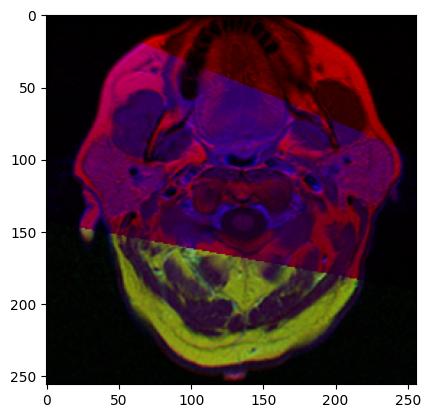

In [ ]:
img = io.imread("/content/drive/MyDrive/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif")
plt.imshow(img)

In [ ]:
img = img * 1./255.
img = cv2.resize(img, (256, 256))
img = np.array(img, dtype=np.float64)
img = np.reshape(img, (1, 256, 256, 3))

In [ ]:
with open('/content/model_fine_tuning_16b_345_3.json', 'r') as json_file:
    json_saved_model = json_file.read()
model1 = tf.keras.models.model_from_json(json_saved_model)
model1.load_weights('/content/drive/MyDrive/classifier-resnet-weights_fine_tuning_16b_345.hdf5')
model1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])

In [ ]:
folder_path = '/content/drive/MyDrive/kaggle_3m/'
ans=[]
for i in range(len(brain_df)):
  img = io.imread(folder_path+brain_df.image_path[i])
  img = img * 1./255.
  img = cv2.resize(img, (256, 256))
  img = np.array(img, dtype=np.float64)
  img = np.reshape(img, (1, 256, 256, 3))
  # img = brain_df['image_path'][i]

  is_defect = model1.predict(img)

  predicted_class = np.argmax(is_defect)
  ans.append(predicted_class)
  # if predicted_class==1:
    # print(i)
  print("Predicted class:", predicted_class)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
Predicted class: 0
1/1 [==============================] - 0s 26ms/step
Predicted class: 0
1/1 [==============================] - 0s 22ms/step
Predicted class: 0
1/1 [==============================] - 0s 23ms/step
Predicted class: 0
1/1 [==============================] - 0s 21ms/step
Predicted class: 0
1/1 [==============================] - 0s 22ms/step
Predicted class: 0
1/1 [==============================] - 0s 21ms/step
Predicted class: 0
1/1 [==============================] - 0s 22ms/step
Predicted class: 0
1/1 [==============================] - 0s 24ms/step
Predicted class: 0
1/1 [==============================] - 0s 23ms/step
Predicted class: 0
1/1 [==============================] - 0s 22ms/step
Predicted class: 0
1/1 [==============================] - 0s 22ms/step
Predicted class: 0
1/1 [==============================] - 0s 21ms/step
Predicted class: 0
1/1 [=====================

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score

In [ ]:
test.shape

(590, 3)

In [ ]:
with open('/content/model_fine_tuning_16b_345_3.json', 'r') as json_file:
  json_saved_model = json_file.read()
model1 = tf.keras.models.model_from_json(json_saved_model)
model1.load_weights('/content/drive/MyDrive/classifier-resnet-weights_fine_tuning_16b_345.hdf5')
model1.compile(loss ='categorical_crossentropy', optimizer=optimizers.Adam(0.0001), metrics= ['accuracy'])
# /content/drive/MyDrive/classifier-resnet-weights_fine_tuning_16b_345.hdf5
# /content/model_fine_tuning_16b_345_3.json
preds1 = model1.predict(test_gen, steps=test_gen.n // batch, verbose=1)
preds1 = np.argmax(preds1, axis=1)
true = np.asarray(test['mask'][:len(preds1)], dtype='int32')
accuracy1 = accuracy_score(true, preds1)
accuracy1 # accuracy - 0.979

36/36 [==============================] - 126s 4s/step


0.9357638888888888

In [ ]:
with open('/content/model_fine_tuning_16b_345_3.json', 'r') as json_file:
  json_saved_model = json_file.read()
model2 = tf.keras.models.model_from_json(json_saved_model)
model2.load_weights('/content/drive/MyDrive/classifier-resnet-weights_fine_tuning_16b_345.hdf5')
model2.compile(loss ='categorical_crossentropy', optimizer=optimizers.Adam(0.0001), metrics= ['accuracy'])

preds2 = model2.predict(test_gen, steps=test_gen.n // batch, verbose=1)
preds2 = np.argmax(preds2, axis=1)
true = np.asarray(test['mask'][:len(preds2)], dtype='int32')

36/36 [==============================] - 5s 111ms/step


In [ ]:
accuracy2 = accuracy_score(true, preds2)
accuracy2 # accuracy - 0.984

0.9357638888888888